<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%204/04_03_Ecobici_NetworkX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Grafos y redes de transporte

##  Parte 2. Teoría de grafos con `NetworkX` 
### Cuestiones prácticas

#### Estructurando la red EcoBici en la Ciudad de Buenos Aires

Como cualquier sistema de transporte, la red de bicicletas puede entenderse como una estructura sencilla de nodos conectados por ejes o arcos. 

Ahora bien, la forma en la que se estructure dicha red puede variar dependiendo del modo en el que dispongamos sus componentes principales. En nuestro caso, ciclistas, estaciones, ciclovías, recorridos, etc. 

Por eso, a la hora de utilizar un grafo para representar una red de transporte debemos considerar algunas cuestiones esenciales. Principalmente, cuáles serán los nodos y como van a conectarse entre sí. 

Una vez resueltas estas definiciones, también será importante tener en cuenta con qué información contamos para caracterizar los nodos y ejes de nuestra red. Esto puede hacernos volver atrás en algunas de nuestras decisiones previas, por eso, la disponibilidad de información no es algo menor. De ello dependerá, por ejemplo, la manera en la que ponderemos (o no) las relaciones entre vértices.

Normalmente, en una red de transporte los nodos se encuentran representados por las estaciones. Por su parte, los ejes pueden tomar la forma de las vías que los conectan - ya sean las calles o carriles que delimitan el recorrido en cuestión -, o incluso, los viajes realizados entre nodos.

En este último caso, los atributos serán diferentes. Un viaje realizado puede caracterizarse por la edad del individuo que se moviliza mientras que el tramo del recorrido puede tener un largo en distancia.

![caption](../imagenes/estructura_red.png)

De tal manera, vamos a reconocer tres dimensiones en las que deberemos ir tomando algunas decisiones para poder representar la red pública de bicicletas como un grafo:

**1. Componentes de la red:**

Como adelantamos previamente, debemos definir cuáles serán las unidades de procesamiento de información (o nodos) de nuestra red. En transporte, tanto los cruces de calles como las estaciones del mismo sistema que estemos estudiando pueden tomar ese rol. 

Dado que la red EcoBici se encuentra organizada en un conjunto delimitado de estaciones, vamos a considerar a estas últimas como los vértices de nuestro grafo y a las rutas transitadas, como la conexión en sí misma. 

En ese sentido, no debemos perder de vista que los viajes realizados entre nodos responden a una necesidad de desplazamiento. Y por lo tanto, pueden asumir distintas formas y sentidos. Esto nos lleva a plantear una segunda cuestión ... 
    
**2. Comportamiento de la red:**

Nuestra red estará constituida por un conjunto de estaciones (identificadas en nuestro dataframe por un nombre o un "identifier") conectadas por los viajes realizados. Estos pueden tener un mismo punto de partida y de llegada, o contrariamente, ir de un conjunto de coordenadas a otros.

Por lo tanto, deberemos definir si nuestro grafo será de tipo dirigido o no, si soportará self-loops y ejes paralelos. 

    
**3. Atributos de la red:**

Por último, vamos a trabajar en la intensidad de las conexiones. Para esto, vamos a evaluar si existe algún patrón de movilidad identificable en el conjunto de caminos más cortos (o `shortest path`) de la red. Para ello, trabajaremos con la distancia (medida en tiempo de uso) como medida de ponderación.

## Sección 1: Armando nuestro grafo

Los datasets con los que vamos a trabajar serán los mismos que utilizamos en la introducción de este módulo. Por lo tanto, vamos a construir un grafo para cada uno de los años para los que contamos con información (2015, 2016, 2017, 2018 y 2019). Empecemos!

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx

In [2]:
# Cargamos datasets de recorridos
df = {}
for i in range(15,20):
    path = 'https://storage.googleapis.com/python_mdg/data_cursos/bici{}_cdn.csv'.format(str(i))
    df[str(i)] = pd.read_csv(path)

In [3]:
df['18'].head()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
0,107148.0,2018-12-31 23:56:42,39.0,Parque Lezama,6,Austria y French,200.0,MASCULINO,27.0
1,140759.0,2018-12-31 23:40:14,7.0,Cementerio de la Recoleta,166,Quintana,115.0,FEMENINO,65.0
2,391310.0,2018-12-31 23:31:39,2.0,Agüero,85,Ecuador,69.0,MASCULINO,24.0
3,487229.0,2018-12-31 23:27:19,31.0,Ministro Carranza,58,Sarandí,77.0,MASCULINO,21.0
4,192675.0,2018-12-31 23:22:29,21.0,Pasco,91,Rincón,106.0,FEMENINO,32.0


La dimensión geográfica es un atributo de interés para representar nuestros grafos. Por lo tanto, vamos a levantar un shape de estaciones disponible en el portal de datos del Gobierno de la Ciudad para poder asignar coordenadas a nuestros datasets.

In [4]:
from shapely import wkt

In [5]:
# y el shape de estaciones que descargamos de DataBA
estaciones_wkt = pd.read_csv('https://storage.googleapis.com/python_mdg/carto_cursos/estaciones_ecobici.csv', 
                             index_col=[0])
proj = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'

In [6]:
# creamos esta función para cargar la geometría como texto
def from_wkt(df, wkt_column, crs=4326):
    
    df["geometry"]= df[wkt_column].apply(wkt.loads) 
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs) 
    
    return gdf

In [7]:
estaciones = from_wkt(estaciones_wkt, 'str_geom').to_crs(proj)

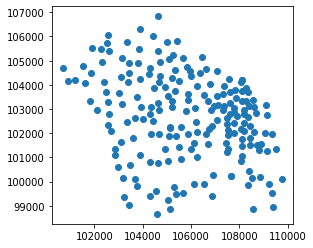

In [8]:
# con ustedes, las estaciones!
estaciones.plot();

In [9]:
print('Total estaciones: {}'.format(len(estaciones)))

Total estaciones: 199


### 1.2. Nodos, ejes y sentido de las conexiones

Antes de seguir avanzando, debemos tener en cuenta que el sistema público de bicicletas fue diseñado para funcionar sobre una red de ciclovías.  Se puede ir de una estación a otra o biceversa, como así también, salir y llegar a la misma estación siempre utilizando una única vía. 

Asimismo, todas las ciclovías tienen una dirección de ida y otra de vuelta. No hay casos en los que haya un sentido y casos donde haya otro, como puede suceder con la red de calles. 

Por lo tanto, estamos frente a un caso de caminos bidireccionales. **Entonces si el orden importa, ¿es nuestra red un grafo dirigido o no dirigido?**

![caption](../imagenes/dirigido_nodirigido.png)

Como vemos en la ilustración, en un grafo dirigido sólo hay un arco entre (por ejemplo) A y B. Se puede ir de A a B pero no de B a A. Suponiendo que estas fuesen nuestras estaciones, la forma que adoptarían en un grafo dirigido sería `A -> B`. 

Ahora bien, como dijimos anteriormente, un ciclista puede ir de A a B o de B a A dependiendo hacia a dónde necesite desplazarse. En nuestro grafo, los viajes tienen direccionalidad y las estaciones podrían conectarse en ambos sentidos (se puede ir de A a B y de B a A). Esto nos deja dos posibilidades.

**a.** Si planteamos un grafo no dirigido, las estaciones deberían tomar la forma `A - B`.

**b.** Si planteamos un grafo dirigido, las estaciones deberían tomar la forma `A <-> B`

Ambas alternativas son posibles, probemos alguna de ellas. Para eso, tomemos un año al azar. Digamos, 2018.

In [10]:
# Antes de armar nuestro grafo revisemos que el dataset sea consistente
print('Estaciones de origen sin informacion:{}'.format(len(df['18'][df['18'].bici_estacion_origen.isna()])))
print('Estaciones de destino sin informacion:{}'.format(len(df['18'][df['18'].bici_estacion_destino.isna()])))

Estaciones de origen sin informacion:0
Estaciones de destino sin informacion:18456


In [11]:
# no contamos con información para varias estaciones de destino
df['18'][df['18'].bici_estacion_destino.isna()]

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
2474,104091.0,2018-12-30 16:06:09,NaN,Esmeralda y Corrientes,175,NaN,NaN,MASCULINO,33.0
8463,294908.0,2018-12-28 17:28:29,NaN,Congreso II,39,NaN,NaN,MASCULINO,33.0
13112,334223.0,2018-12-27 19:01:51,NaN,Parque Patricios,21,NaN,NaN,MASCULINO,26.0
13972,381762.0,2018-12-27 16:32:25,NaN,Rincón,106,NaN,NaN,FEMENINO,27.0
14461,446321.0,2018-12-27 14:57:24,NaN,Facultad de Psicologia,169,NaN,NaN,MASCULINO,23.0
...,...,...,...,...,...,...,...,...,...
2970238,472198.0,2018-01-01 07:42:27,NaN,Instituto Leloir,74,NaN,NaN,MASCULINO,52.0
2970322,320736.0,2018-01-01 05:08:17,NaN,Rivarola,68,NaN,NaN,MASCULINO,26.0
2970357,183777.0,2018-01-01 03:43:08,NaN,Ravignani y Guatemala,182,NaN,NaN,MASCULINO,20.0
2970387,131371.0,2018-01-01 02:53:03,NaN,Velasco,129,NaN,NaN,MASCULINO,46.0


In [12]:
# hay varias estrategias de imputación, una podría ser suponer que estos movimientos son self-loops
df['18'].bici_estacion_destino.fillna(df['18'].bici_estacion_origen)

0          200.0
1          115.0
2           69.0
3           77.0
4          106.0
           ...  
2970474     54.0
2970475     54.0
2970476     31.0
2970477    110.0
2970478    183.0
Name: bici_estacion_destino, Length: 2970479, dtype: float64

In [13]:
# Generamos un grafo de la red de transporte donde el nodo es la estacion y el arco el viaje o recorrido
def graphmaker(df, origen, destino, atributo, constructor=None):
    '''
    Devuelve un grafo compuesto por estaciones(nodos) y recorridos(vinculos) para cada dataframe.
    ...
    Argumentos:
    
    df = dataframe de recorridos
    origen = Serie del dataframe referenciando la estacion de origen del grafo
    destino = Serie del dataframe referenciando la estacion de destino del grafo
    '''
        
    if len(df[df[origen].isna()])>0:
        print('Imputando estaciones de origen')
        df[origen] = df[origen].fillna(df[destino])
        
    if len(df[df[destino].isna()])>0:
        print('Imputando estaciones de destino')          
        df[destino] = df[destino].fillna(df[origen])

    if len(df[df[atributo].isna()])>0:
        print('Imputando promedios para el atributo')
        df[atributo] = df[atributo].fillna(df[atributo].mean())
    
    bicigrafo = nx.from_pandas_edgelist(df=df,
                                        source=origen,target=destino,
                                        edge_attr=atributo,
                                        create_using=constructor)
    
    return bicigrafo

In [14]:
# Probemos la funcion para crear un grafo a partir de un dataframe cualquiera
b18 = graphmaker(df=df['18'],origen='bici_nombre_estacion_origen',
                 destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso')

Imputando estaciones de destino
Imputando promedios para el atributo


In [15]:
# Ahora veamos qué nos devuelve. Como no especificamos el constructor, un grafo no dirigido.
print(type(b18))

<class 'networkx.classes.graph.Graph'>


In [16]:
print("Se crea un Grafo de %r nodos con %r arcos" % (b18.number_of_nodes(), b18.number_of_edges())) 

Se crea un Grafo de 199 nodos con 19575 arcos


Siguiendo esta lógica, obtenemos un grafo de 199 nodos con un poco menos de 20.000 arcos. 
Hasta acá, estructuramos una red de conexiones a partir de un dataframe de pandas que representa los vínculos entre pares de estaciones. Aunque, ¿cómo podemos estar seguros de que esta representación es la correcta? 

Primero veamos cuántas combinaciones posibles hay en el universo de estaciones disponible. Así sabremos, cuántos son los pares únicos de nodos que podrían estar conectandose ...

In [17]:
# agrupamos las estaciones por origen y destino (el dataframe se modifico inplace en nuestra funcion!)
agrupado = df['18'].groupby(['bici_nombre_estacion_origen',
                             'bici_nombre_estacion_destino']).size().reset_index(name='viajes')

In [18]:
agrupado.head()

,bici_nombre_estacion_origen,bici_nombre_estacion_destino,viajes
0,15 de Noviembre,15 de Noviembre,525
1,15 de Noviembre,25 de Mayo,2
2,15 de Noviembre,9 de Julio,7
3,15 de Noviembre,Acevedo,26
4,15 de Noviembre,Acuña de Figueroa,10


El groupby toma una estacion y la contrasta contra todas las restantes computando así la cantidad de casos que hay para cada par único de orígenes y destinos. 

In [19]:
# de minima, sabemos que las combinaciones posibles entre estaciones de origen y destino son
len(agrupado)

38334

Ahora, vemos que las combinaciones posibles son casi el doble de los arcos que obtuvimos inicialmente. Entonces, ¿estamos perdiendo vínculos si trabajamos bajo la forma de un  `grafo no dirigido`?

Primero, tratemos de entender cuál sería el universo de conexiones posibles en función del tipo de grafo y después tratemos de contrastar las conexiones que efectivamente se producen.

En los grafos no dirigidos no importa el orden de la conexión porque los nodos pueden vincularse en ambos sentidos. Esto hace que la cantidad máxima de ejes entre nodos se piense como una combinación de "n" elementos tomados de "k" en "k". 

![caption](../imagenes/formulas.png)

Sin embargo, nuestro problema responde más bien a una permutación que a una combinación. Principalmente, porque el orden de las conexiones sí importa. Cada par de estaciones es único, e ir de A a B o de B a A no es lo mismo para nosotros. Entonces, no deberíamos utilizar en el denominador `k!` para conocer el número máximo de pares `origen - destino`. 

In [20]:
# Primero armamos una funcion para devolver el factorial de un nro.
def factorial (*n):
    for x in n:
        fac=1
    for y in range(1,x+1):
        fac=fac*y
    return fac 

En un grafo no dirigido no se tiene en cuenta el orden. `A-B | B-A` es lo mismo (se divide por 2 para contar la combinación de pares sólo una vez!)

In [21]:
# Si nos diera lo mismo ir de A a B o de B a A, la cantidad de ejes máximos rondaría los ...
Lmax = factorial(200)/((factorial(200-2))*(factorial(2)))
Lmax

19900.0

En otras palabras, algo bastante similar al total de ejes que contamos en nuestro grafo no dirigido. Esto quiere decir que, si el orden no importa, estamos dejando de contar conexiones que son únicas por su sentido. Tomemos el grafo de 2018 y revisemos cómo se conectan un par de estaciones al azar. 

In [22]:
conexiones = pd.DataFrame(b18.edges(data=True))
conexiones.columns = ['origen','destino','atributo']
conexiones.loc[((conexiones['origen']=='15 de Noviembre') | (conexiones['origen']=='25 de Mayo')) &
              ((conexiones['destino']=='15 de Noviembre') | (conexiones['destino']=='25 de Mayo'))]

,origen,destino,atributo
18055,25 de Mayo,25 de Mayo,{'bici_tiempo_uso': 9.0}
18078,25 de Mayo,15 de Noviembre,{'bici_tiempo_uso': 53.0}
19275,15 de Noviembre,15 de Noviembre,{'bici_tiempo_uso': 6.0}


Bien, hay autoconexiones. Aunque curiosamente, en el grafo no se computó el par `15 de Noviembre - 25 de Mayo` pero sí `25 de Mayo - 15 de Noviembre`. Esto quiere decir que, al momento de instanciarse se consideró solamente un par de estaciones, sin importar su sentido.

In [23]:
# Corroborémoslo, ese par no está en el grafo!
conexiones.loc[(conexiones['origen']=='15 de Noviembre') & (conexiones['destino']=='25 de Mayo')]

,origen,destino,atributo


... pero sí en el dataset de viajes. Constatemos ahora en nuestra base que el recorrido `15 de Noviembre -  25 de Mayo` efectivamente existe. 

In [24]:
agrupado.columns = ['origen','destino','viajes']

agrupado.loc[((agrupado['origen']=='15 de Noviembre') | (agrupado['origen']=='25 de Mayo')) & 
             ((agrupado['destino']=='15 de Noviembre') | (agrupado['destino']=='25 de Mayo'))]

,origen,destino,viajes
0,15 de Noviembre,15 de Noviembre,525
1,15 de Noviembre,25 de Mayo,2
190,25 de Mayo,15 de Noviembre,7
191,25 de Mayo,25 de Mayo,1313


La clase `graph` que utilizamos para construir nuestro grafo considera los self loops pero no contempla ejes múltiples. Es por eso que los que son pares únicos de nodos no se procesan como tales. Ir de 15 de Noviembre a 25 de Mayo o vicebersa es lo mismo y se computa el primer valor disponible en el orden de indexación cuando aplicamos el método `nx.from_pandas_edgelist`. 

Ahora que sabemos que nuestros recorridos son singulares y que no nos da lo mismo ir de un lado a otro, podemos decir que la `direccionalidad` es un atributo que debemos respetar para poder crear un grafo que represente correctamente el comportamiento de la red EcoBici. Pero, ¿cómo lo conseguimos?

Primero evaluemos qué cantidad de conexiones posibles habríamos de esperar si respetamos el sentido de los ejes. Es decir, si se tiene en cuenta que ir de A-B | B-A no es lo mismo.

In [25]:
# calculamos el límite máximo de pares origen - destino en un contexto dirigido
Lmax = factorial(200)/factorial(200-2)
Lmax

39800.0

Ya no dividimos por 2 porque nuestras conexiones son singulares. Así obtenemos un valor mucho más parecido al total que obtuvimos en nuestro dataframe de nodos agrupados. 

Es decir, si conderamos singularmente ir de A a B y de B a A a lo largo de toda la red, el total de combinaciones posibles entre pares únicos de estaciones debería rondar en ese valor. Y decimos debería porque es posible que no todos los nodos estén conectados de manera adyacente.

Nuestro valor máximo de pares únicos conectados será `39800`. Ahora, podremos tener más o menos ejes según haya adyacencia entre nodos, como así también si existen relaciones paralelas o múltiples. Esta es la otra cuestión de relevancia!

Pero antes veamos qué sucede trabajando con un `grafo dirigido`. 

In [26]:
# creamos un grafo dirigido
b18_di = graphmaker(df=df['18'],origen='bici_nombre_estacion_origen',
                    destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso',
                    constructor=nx.DiGraph)

In [27]:
print("Se crea un Grafo de %r nodos con %r arcos" % (b18_di.number_of_nodes(), b18_di.number_of_edges()))

Se crea un Grafo de 199 nodos con 38334 arcos


![caption](../imagenes/movimientos.png)

En este caso, el número de arcos se asemeja mucho más al total de pares únicos que obtuvimos agrupando nodos por origen y destino. Ahora bien, ¿solamente respetando la direccionalidad es que garantizamos la totalidad de ejes o conexiones presentes en la red?

En realidad no. Si bien es cierto que nos acercamos bastante al valor máximo que estipulamos en la permutación, lo que alcanzamos con el grafo dirigido es un valor cercano al total de conexiones que se dan *al menos una vez* entre pares adyacentes de nodos. Más concretamente, no debemos perder de vista que la clase `DiGraph` de NetworkX tampoco soporta ejes mútltiples. Por ende, si hay un viaje que se efectúa más de una vez entre un mismo par de nodos, el mismo no será computado.

Por lo tanto, sabemos que un grafo dirigido nos devolverá al menos una conexión entre A -> B | B -> A si esta existe. Pero si hubiera más de un viaje en la misma direccionalidad no se va a contar dos veces.

Por eso, la `direccionalidad` no es lo único que tenemos que tener en cuenta para instanciar nuestro grafo. Sino también la posibilidad de soportar `ejes paralelos o múltiples`.

In [28]:
# probemos ahora con un multigrafo no dirigido!
b18_multi = graphmaker(df=df['18'],origen='bici_nombre_estacion_origen',
                       destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso',
                       constructor=nx.MultiGraph)

In [29]:
print("Se crea un Grafo de %r nodos con %r arcos" % (b18_multi.number_of_nodes(), b18_multi.number_of_edges()))

Se crea un Grafo de 199 nodos con 2970479 arcos


Contemplando ejes múltiples, vemos que la cantidad de conexiones sube considerablemente. Pero no perdamos de vista que es un grafo no dirigido y que la relación es `A - B`. Es decir, no hay direccionalidad. No se respeta la singularidad de la conexión como con la clase `DiGraph`, pero al soportar ejes múltiples, se cuenta ir de A a B y vicebersa tantas veces como aparezca el par de nodos en el dataframe. 

Está mal? No necesariamente. Es una forma de representar la red, la cual implica suponer que las estaciones están conectadas por ciclovías bidireccionales. Esto, sin tener en cuenta el sentido de la conexión.

In [30]:
# tratemos por último con un multigrafo dirigido
b18_multidi = graphmaker(df=df['18'],origen='bici_nombre_estacion_origen',
                         destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso', 
                         constructor=nx.MultiDiGraph)

In [31]:
print("Se crea un Grafo de %r nodos con %r arcos" % (b18_multidi.number_of_nodes(), b18_multidi.number_of_edges()))

Se crea un Grafo de 199 nodos con 2970479 arcos


Tanto dirigido como no dirigido, pero contemplando ejes múltimos obtenemos la misma cantidad de conexiones. Hagamos un último testeo para ver en qué se diferenciarían ambas alternativas. 

Para eso, vamos a volver sobre el mismo para de estaciones con las que trabajamos antes y ver las diferencias de frecuencias que hay en el número de ejes para cada clase de grafo.

In [32]:
def evalua_resultados(grafo, origen='15 de Noviembre', destino='25 de Mayo'):
    
    print("Ejes totales entre pares:")
    print("*************************")
    
    print("O-D:{}".format(grafo.number_of_edges(u=origen,v=destino)))
    print("D-O:{}".format(grafo.number_of_edges(u=destino,v=origen)))
    print("O-O:{}".format(grafo.number_of_edges(u=origen,v=origen)))
    print("D-D:{}".format(grafo.number_of_edges(u=destino,v=destino)))

    print("Ejes totales:{}".format(grafo.number_of_edges()))

In [33]:
# grafo no dirigido
evalua_resultados(b18)

Ejes totales entre pares:
*************************
O-D:1
D-O:1
O-O:1
D-D:1
Ejes totales:19575


In [34]:
# grafo dirigido
evalua_resultados(b18_di)

Ejes totales entre pares:
*************************
O-D:1
D-O:1
O-O:1
D-D:1
Ejes totales:38334


In [35]:
# multigrafo
evalua_resultados(b18_multi)

Ejes totales entre pares:
*************************
O-D:9
D-O:9
O-O:525
D-D:1313
Ejes totales:2970479


In [36]:
# multigrafo dirigido
evalua_resultados(b18_multidi)

Ejes totales entre pares:
*************************
O-D:2
D-O:7
O-O:525
D-D:1313
Ejes totales:2970479


In [37]:
agrupado.viajes.sum()

2970479

Estudiando más de cerca lo que sucede entre las estaciones `25 de Mayo` y `15 de Noviembre` podemos decir que la principal diferencia es cómo se contemplan los ejes. Mientras en un multigrafo no dirigido se tratan como relaciones recíprocas, en uno dirigido se diferencian según el sentido.

Lo importante, es que, si instanciamos nuestro grafo con eje paralelos vamos a poder respetar el total de viajes de todos los usuarios de la red. Ahora, la manera como trabajemos el comportamiento de la misma dependerá tanto de su topología como de lo que estemos buscando representar.

In [38]:
# creemos el resto de los grafos, los vamos a becesitar!
b19_multidi = graphmaker(df=df['19'],origen='bici_nombre_estacion_origen',
                         destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso', 
                         constructor=nx.MultiDiGraph)

b15_multidi = graphmaker(df=df['15'],origen='bici_nombre_estacion_origen',
                         destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso', 
                         constructor=nx.MultiDiGraph)

b16_multidi = graphmaker(df=df['16'],origen='bici_nombre_estacion_origen',
                         destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso', 
                         constructor=nx.MultiDiGraph)

b17_multidi = graphmaker(df=df['17'],origen='bici_nombre_estacion_origen',
                         destino='bici_nombre_estacion_destino', atributo='bici_tiempo_uso', 
                         constructor=nx.MultiDiGraph)

Imputando estaciones de destino
Imputando promedios para el atributo
Imputando estaciones de destino
Imputando promedios para el atributo
Imputando estaciones de destino
Imputando promedios para el atributo
Imputando estaciones de destino
Imputando promedios para el atributo


## Sección 2: representando la red

Avancemos un poco más. Ahora que sabemos que no existe una única forma de representar nuestra red tratemos de ver cómo esto se relaciona con su representación gráfica. 

Si bien es cierto que nuestra representación debe ajustarse lo más posible a la realidad (respetar ejes paralelos, direccionalidad, etc) no debemos perder de vista que los grafos, como estructura de datos, es un tipo de representación costosa en memoria. 

Por lo tanto, a la hora de representar gráficamente una red también debemos pensar en qué es lo que estamos buscando reflejar. En nuestro caso, la red EcoBici, es un sistema eminentemente de caminos adyacentes (un usuario toma una bicicleta en una estación de origen, devolviéndola en otra de destino).

Por ende, tratar la red como un grafo no dirigido únicamente para ver estas relaciones puede que no esté tan mal. Veamos cómo resulta...

In [39]:
# rearmamos graphmaker para poder incorporar las coordenadas de las estaciones
def graphmaker(df, origen, destino, atributo, constructor=None):
    '''
    Devuelve un grafo compuesto por estaciones(nodos) y recorridos(vinculos) para cada dataframe.
    ...
    Argumentos:
    
    df = dataframe de recorridos
    origen = Serie del dataframe referenciando la estacion de origen del grafo
    destino = Serie del dataframe referenciando la estacion de destino del grafo
    '''    
        
    if len(df[df[origen].isna()])>0:
        print('Imputando estaciones de origen')
        df[origen] = df[origen].fillna(df[destino])
        
    if len(df[df[destino].isna()])>0:
        print('Imputando estaciones de destino')          
        df[destino] = df[destino].fillna(df[origen])

    if len(df[df[atributo].isna()])>0:
        print('Imputando promedios para el atributo')
        df[atributo] = df[atributo].fillna(df[atributo].mean())
        
    estaciones_en_viajes = pd.concat([df[origen].astype(int),
                                      df[destino].astype(int)]).unique()
    
    # nos quedamos con las estaciones para las que tenemos coordenadas
    estaciones_en_df = estaciones[estaciones.NRO_EST.isin(estaciones_en_viajes)].copy()
    estaciones_en_df['coordenadas'] = list(zip(estaciones_en_df.geometry.y, 
                                               estaciones_en_df.geometry.x))
    coordenadas = dict(zip(estaciones_en_df.NRO_EST, estaciones_en_df.coordenadas))
    
    # filtramos coordenadas existentes en nuestras estaciones de origen y destino
    df = df[df[origen].isin(pd.Series(coordenadas.keys()))].copy()
    df = df[df[destino].isin(pd.Series(coordenadas.keys()))].copy()
    
    bicigrafo = nx.from_pandas_edgelist(df=df,
                                        source=origen,target=destino,
                                        edge_attr=atributo,
                                        create_using=constructor)
    
    # agregamos las coordenadas al grafo
    for k,v in coordenadas.items():
        bicigrafo.nodes[k]['coord'] = v
    
    return bicigrafo

In [40]:
# instanciamos nuestro grafo con el nuevo atributo de coordenadas
G19 = graphmaker(df=df['19'],
                 origen='bici_estacion_origen',
                 destino='bici_estacion_destino', 
                 atributo='bici_tiempo_uso')

Imputando estaciones de destino


In [41]:
import matplotlib.pyplot as plt

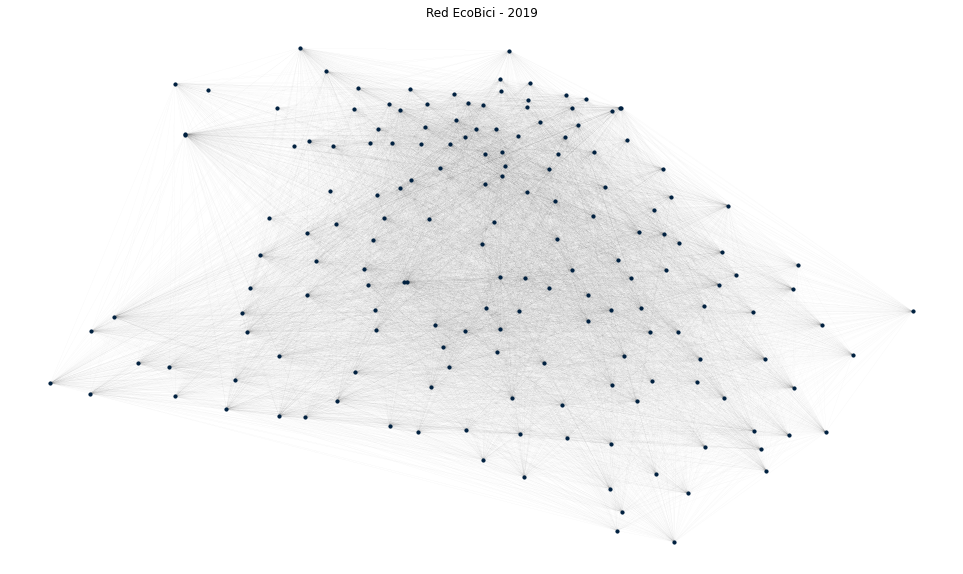

In [42]:
# y lo graficamos! 
fig, ax = plt.subplots(figsize=(17,10))

pos = nx.get_node_attributes(G19,'coord')

nx.draw_networkx_edges(G=G19, pos=pos, width=0.01)

nx.draw_networkx_nodes(G=G19,        
                       pos=pos, 
                       node_size=10,
                       node_color='#00203FFF')

ax.set_axis_off()
ax.set_title('Red EcoBici - 2019');

## **Ejercitación**

Ahora que vimos distintas formas de representar nuestra red y cómo ubicarla en el espacio ...

1. Utilizar la función `graphmaker` e instanciar un grafo para cada uno de los años disponibles.
   Pista: nosotros queremos ver relaciones adyacentes, tener cuidado con el tipo de clase que vamos a utilizar! 
2. Armar una función que consuma cada grafo, lo plotee en ejes diferentes y asigne un color por año a los nodos. 

In [43]:
# Desarrollar ejercicio

### Solución

In [44]:
# creamos los grafos restantes
G15 = graphmaker(df=df['15'],
                 origen='bici_estacion_origen',
                 destino='bici_estacion_destino', 
                 atributo='bici_tiempo_uso')

G16 = graphmaker(df=df['16'],
                 origen='bici_estacion_origen',
                 destino='bici_estacion_destino', 
                 atributo='bici_tiempo_uso')

G17 = graphmaker(df=df['17'],
                 origen='bici_estacion_origen',
                 destino='bici_estacion_destino', 
                 atributo='bici_tiempo_uso')

G18 = graphmaker(df=df['18'],
                 origen='bici_estacion_origen',
                 destino='bici_estacion_destino', 
                 atributo='bici_tiempo_uso')

Imputando estaciones de destino
Imputando estaciones de destino
Imputando estaciones de destino
Imputando estaciones de destino


In [45]:
# y los graficamos!
def plotea_grafos(G1, G2, color1, color2, año1, año2):
    # y lo graficamos! 
    fig = plt.figure(figsize=(20,11))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    pos1 = nx.get_node_attributes(G1,'coord')
    pos2 = nx.get_node_attributes(G2,'coord')

    nx.draw_networkx_edges(G=G1, pos=pos1, width=0.01, ax=ax1)
    nx.draw_networkx_nodes(G=G1,pos=pos1, node_size=10,node_color=color1, ax=ax1)
    
    nx.draw_networkx_edges(G=G2, pos=pos2, width=0.01, ax=ax2)
    nx.draw_networkx_nodes(G=G2,pos=pos2, node_size=10,node_color=color2, ax=ax2)

    
    ax1.set_axis_off()
    ax1.set_title('Red EcoBici - {}'.format(año1))
    
    ax2.set_axis_off()
    ax2.set_title('Red EcoBici - {}'.format(año2));

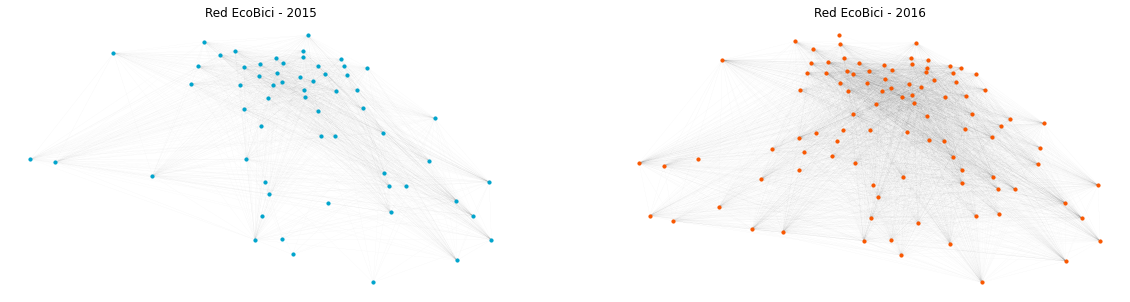

In [46]:
plotea_grafos(G1=G15, G2=G16, color1='#00A4CCFF', color2='#F95700FF', año1='2015', año2='2016')

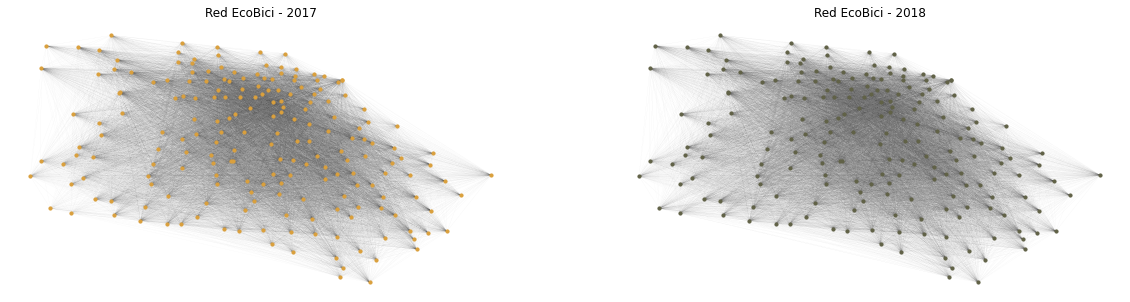

In [47]:
plotea_grafos(G1=G17, G2=G18, color1='#DAA03DFF', color2='#616247FF', año1='2017', año2='2018')

## Sección 3: métricas y atributos de la red

Ahora que vimos la implicancia de cada tipo de representación, exploremos algunas métricas y veamos qué poder decir sobre la evolución de la red de bicicletas.

### 3.1. Cantidad de nodos y ejes

In [48]:
# Cantidad de nodos(estaciones) y ejes(recorridos) de cada dataset
n15, e15 = b15_multidi.number_of_nodes(), b15_multidi.number_of_edges()
n16, e16 = b16_multidi.number_of_nodes(), b16_multidi.number_of_edges()
n17, e17 = b17_multidi.number_of_nodes(), b17_multidi.number_of_edges()
n18, e18 = b18_multidi.number_of_nodes(), b18_multidi.number_of_edges()
n19, e19 = b19_multidi.number_of_nodes(), b19_multidi.number_of_edges()

In [49]:
# Evolucion de la cantidad de estaciones y recorridos realizados entre 2015 y 2019 
evolucion = pd.DataFrame({'Año':['2015','2016','2017','2018','2019'], 
                          'Nodos':[n15,n16,n17,n18,n19], 
                          'Ejes':[e15,e16,e17,e18,e19]})

In [50]:
evolucion

,Año,Nodos,Ejes
0,2015,66,503867
1,2016,102,716244
2,2017,202,1886184
3,2018,199,2970479
4,2019,170,204107


In [51]:
# El grado promedio por año para nuestros grafos dirigidos
evolucion['Grado_promedio'] = round(evolucion['Ejes']/evolucion['Nodos'],1)

In [52]:
evolucion

,Año,Nodos,Ejes,Grado_promedio
0,2015,66,503867,7634.3
1,2016,102,716244,7022.0
2,2017,202,1886184,9337.5
3,2018,199,2970479,14927.0
4,2019,170,204107,1200.6


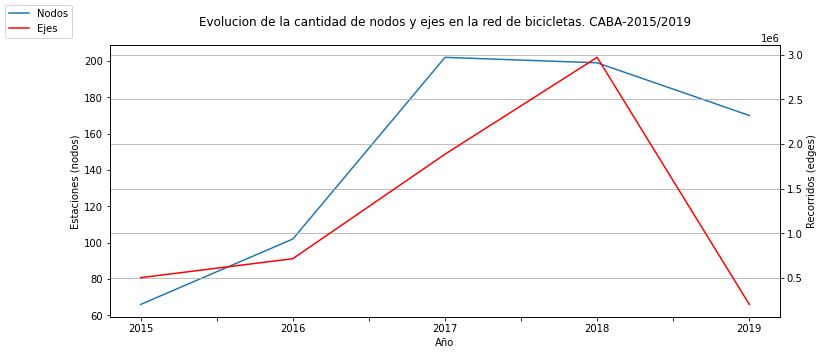

In [53]:
# Vemos como evolucionaron la cantidad de nodos y edges
ax = evolucion.plot(x="Año", y="Nodos", figsize=(12,5),legend=False)
ax2 = ax.twinx()
evolucion.plot(x="Año", y="Ejes", ax=ax2, figsize=(12,5), legend=False, color="r")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Estaciones (nodos)")
ax2.set_ylabel("Recorridos (edges)")
plt.title('Evolucion de la cantidad de nodos y ejes en la red de bicicletas. CABA-2015/2019', y=1.05)
plt.grid();

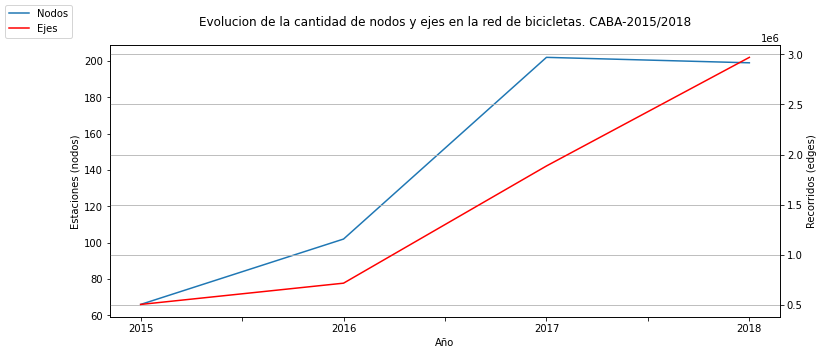

In [54]:
# Dejamos afuera a 2019 (no incluye todos los meses, solamente hasta febrero)
ax = evolucion.iloc[:4].plot(x="Año", y="Nodos", figsize=(12,5),legend=False)
ax2 = ax.twinx()
evolucion.iloc[:4].plot(x="Año", y="Ejes", ax=ax2, figsize=(12,5), legend=False, color="r")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Estaciones (nodos)")
ax2.set_ylabel("Recorridos (edges)")
plt.title('Evolucion de la cantidad de nodos y ejes en la red de bicicletas. CABA-2015/2018', y=1.05)
plt.grid();

In [55]:
print('Entre 2016 y 2017, los nodos de la red EcoBici creciieron un %s%%' % round((n17/n16-1)*100,2)) 

Entre 2016 y 2017, los nodos de la red EcoBici creciieron un 98.04%


In [56]:
print('Por su parte, la cantidad de recorridos (ejes) crecio un %s%%'% round((e17/e16-1)*100,2))

Por su parte, la cantidad de recorridos (ejes) crecio un 163.34%


En primera instancia, algo que podemos ir viendo sobre nuestra red es que el volumen de nodos y conexiones entre los mismos es creciente a lo largo de los años. Ahora, enfoquemonos en un año en concreto y evaluemos cuáles fueron los nodos que más conexiones establecieron.

In [57]:
# esta es una función auxiliar para plotear barras!
def plotear_barras_horizontales(df, bar_color, titulo):
    plt.style.use('ggplot')
    df.plot.barh(color=bar_color, figsize=(12,6))
    
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    frame.set_linewidth(1)
    
    plt.title(titulo)
    plt.ylabel(None)
    plt.xlabel(df.columns[0])
    
    plt.show()

In [58]:
# ... que utilizaremos en nuestra función de centralidad!
def centralidad(grafo, medida, top, titulo, bar_color):
    node_degree = pd.DataFrame(list(grafo.degree(grafo.nodes())))
    node_degree.columns = ['estacion', 'node degree']
    node_degree.index = node_degree.estacion
    node_degree = node_degree.sort_values(by='node degree', ascending=False)
    
    degree_centrality = nx.degree_centrality(G=grafo)
    degree_centrality = pd.DataFrame(degree_centrality.values(), index=degree_centrality.keys())
    degree_centrality.columns = ['degree_centrality'] 
    degree_centrality = degree_centrality.sort_values(by='degree_centrality', ascending=False)

    if medida == 'node_degree':
        plotear_barras_horizontales(df=node_degree.head(top), bar_color=bar_color, titulo=titulo)
        
    if medida == 'degree_centrality':
        plotear_barras_horizontales(df=degree_centrality.head(top), bar_color=bar_color, titulo=titulo)

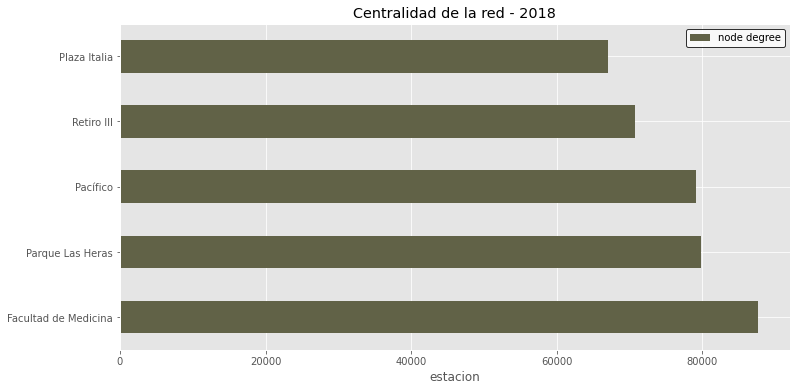

In [59]:
centralidad(grafo=b18_multidi, medida='node_degree',
            top=5, titulo='Centralidad de la red - 2018', bar_color='#616247FF')

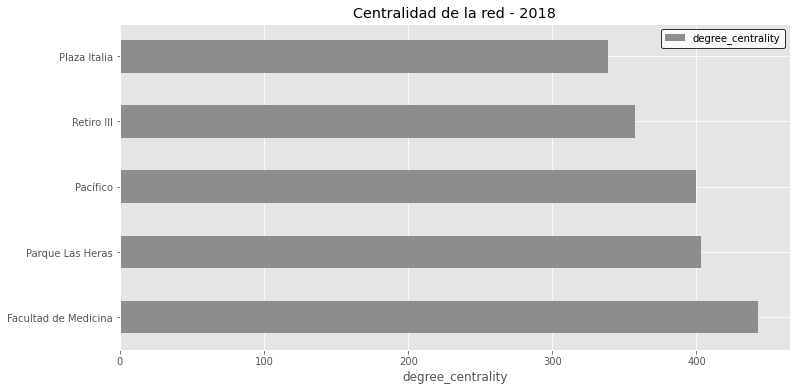

In [60]:
centralidad(grafo=b18_multidi, medida='degree_centrality',
            top=5, titulo='Centralidad de la red - 2018', bar_color='#8d8d8d')

In [61]:
# Asi obtendriamos el/los nodo/s con mayor degree centrality
def nodos_con_mayor_degree_centrality(G):

    # Calculamos el degree centrality para el grafo G
    deg_cent = nx.degree_centrality(G)

    # Convertimos el diccionario en una lista y calculamos el valor maximo
    max_dc = max(list(deg_cent.values()))

    # Creamos un set para guardar valores unicos
    nodes = set()

    # Iteramos sobre cada key del diccionario
    for k, v in deg_cent.items():

        # y comparamos el valor iterado con el maximo que gaurdamos previamente
        if v == max_dc:

            # si alcanza dicho valor lo guardamos en el set
            nodes.add(k)

    return nodes

In [62]:
# estos serian los nodos con mayor degree centrality
max_dc = nodos_con_mayor_degree_centrality(G=b18_multidi)
print(max_dc)

{'Facultad de Medicina'}


Por lo pronto, durante 2018, la estación más utilizada fue `Facultad de Medicina`. Ahora bien, ¿cómo fue el comportamiento de las conexiones de este nodo con el resto?

### 3.1. Direccionalidad de los nodos centrales

In [63]:
def evalua_conexiones_del_nodo(grafo, estacion):
    
    nodos = list(grafo.nodes())
    conexiones_dirigidas_u = {}
    conexiones_dirigidas_v = {}
    
    # registramos todas las conexiones dirigidas de la estacion
    for n in nodos:
        conexiones_dirigidas_u[n] = grafo.number_of_edges(u=estacion,v=n)
        conexiones_dirigidas_v[n] = grafo.number_of_edges(u=n,v=estacion)
    
    return conexiones_dirigidas_u, conexiones_dirigidas_v

In [64]:
# Creamos todas las conexiones en sentido u/v del nodo Facultad de Medicina
estacion_u, estacion_v = evalua_conexiones_del_nodo(grafo=b18_multidi, estacion='Facultad de Medicina')

In [65]:
# y armamos un dataframe para guardar las conexiones en ambas direcciones
estacion_dfu = pd.DataFrame(estacion_u.values(), estacion_u.keys())
estacion_dfu.columns = ['conexiones_u']

estacion_dfv = pd.DataFrame(estacion_v.values(), estacion_v.keys())
estacion_dfv.columns = ['conexiones_v']

estacion_df =estacion_dfu.join(estacion_dfv).copy()
estacion_df['conexiones'] = estacion_df.conexiones_u + estacion_df.conexiones_v 

In [66]:
# sabemos que el resultado es correcto, porque
estacion_df.conexiones.sum()

87609

In [67]:
# es igual al grado del nodo
b18_multidi.degree['Facultad de Medicina']

87609

In [68]:
# Por lo tanto sabemos que en esta estacion, la mayoria de las conexiones fueron self loops
estacion_df.sort_values(by='conexiones', ascending=False).head(1)

,conexiones_u,conexiones_v,conexiones
Facultad de Medicina,2117,2117,4234


Algo adicional que vemos con este análisis es que, en la estación más usada de la red durante 2018, los usuarios retiraron y volvieron a depositar su bicicleta en la misma estación.

### 3.2. Tiempo de uso

In [69]:
# Calculamos el par de estaciones con mayor tiempo de uso donde Facultad de Medicina este involucrada
tiempo_de_uso = {}

for u,v,d in b18_multidi.edges(data=True):
    
    # revisamos si el nodo 1 se encuentra involucrado:
    if 'Facultad de Medicina' in [u,v]:
        
        # y le cambiamos el valor de su peso
        tiempo_de_uso[u,v] = d

In [70]:
# recorrido mas largo de la red involucrando a Facultad de Medicina
max(dict(tiempo_de_uso).items(), key=lambda x: x[1]['bici_tiempo_uso'])

(('Facultad de Medicina', 'Plaza Houssay'), {'bici_tiempo_uso': 1179.0})

In [71]:
# El tiempo promedio de uso para todo el año de Facutad de Medicina con todas sus conexiones adyacentes
np.mean([v['bici_tiempo_uso'] for k,v in tiempo_de_uso.items()])

53.16830652287678

## **Ejercitación**

Ya sabemos que en 2018, la estación con mayor cantidad de conexiones fue `Facultda de Medicina`. Ahora, responder: 

1. ¿Tuvo esta estación el mismo grado de centralidad para los años restantes?
2. ¿Cuál fue el recorrido más largo para las estaciones con mayor degree centrality en los demás años?
3. ¿ Y el tiempo promedio de las estaciones centrales para todos los años 

### Respuesta

In [72]:
# responder aca

### 3.3.  Conexiones direccionales: in y out degree

Si recuerdan, dijimos que en un grafo dirigido el grado de un nodo es el resultado de las conexiones entrantes y salientes. Veamos para el mismo año con el que venimos trabajando cómo es este comportamiento y su relación con el grado del nodo en las estaciones de mayor centralidad. 

In [73]:
# Creamos una funcion para devolver un dataframe con el grado del nodo, y las conexiones entrantes/salientes
def ndg(grafo):
    '''
    Devuelve un df con cada nodo, su degree, in_degree y out_degree
    '''
    
    ndg = grafo.degree()
    idg = grafo.in_degree()
    odg = grafo.out_degree()
    
    estacion = [k for k,v in ndg]
    in_degree = [v for k,v in idg]
    out_degree = [v for k,v in odg]
    node_degree = [v for k,v in ndg]
    
    df = pd.DataFrame(estacion).reset_index()
    df.drop(columns='index', inplace=True)
    df.columns = ['estacion']
    df['in_degree'],df['out_degree'],df['node_deg'] = in_degree, out_degree, node_degree
    
    return df

In [74]:
# Instanciamos la funcion ...
ndg18 = ndg(b18_multidi)

In [75]:
ndg18[ndg18.estacion=='Facultad de Medicina']

,estacion,in_degree,out_degree,node_deg
31,Facultad de Medicina,44003,43606,87609


In [76]:
def plotea_node_degree_estaciones(df):
    plt.figure(figsize=(15,6))
    plt.plot('estacion', 'node_deg', data=df, marker='o', markerfacecolor='blue', 
             markersize=7, color='skyblue', linewidth=3, label='node_degree')
    plt.plot('estacion', 'in_degree', data=df, marker='', color='red', linewidth=1)
    plt.plot('estacion', 'out_degree', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')

    plt.title('Node, In y Out degree - Estaciones Ecobici 2018',y=1.02)
    plt.xticks(np.arange(len(df)),df['estacion'] , fontsize=9, rotation=45)

    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()    
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    frame.set_linewidth(1)
    plt.grid(axis='y', alpha=0.5);

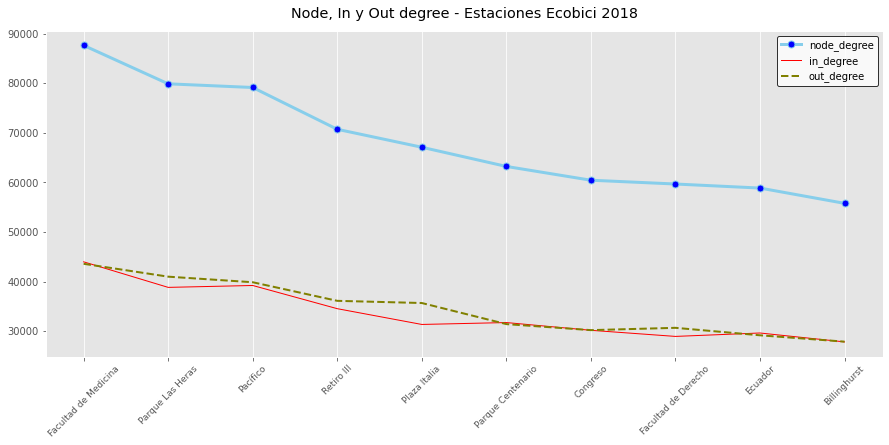

In [77]:
# y graficamos!
plotea_node_degree_estaciones(df=ndg18.sort_values(by='node_deg', ascending=False).head(10))

### 3.4. Distribucion de grados y matrices de adyacencia

Algo de lo que vimos en la evolución de nodos y ejes es que, la cantidad de ambos era incremental. Ahora evaluemos cómo es su distribución para un mismo año. Esto también nos dará una noción sobre cómo están conectados los nodos y cuan completas son las conexiones adyacentes del grafo ...

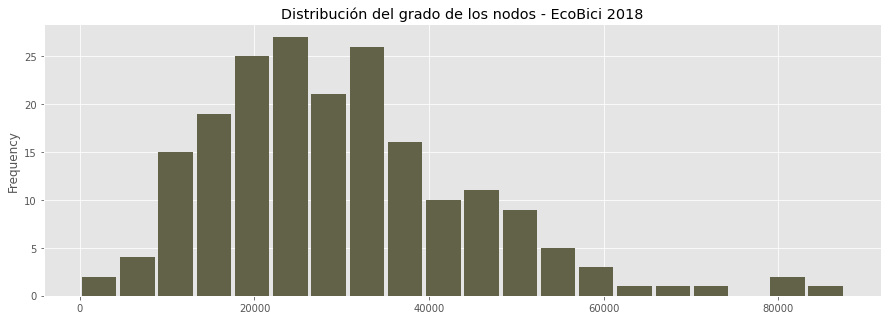

In [78]:
plt.figure(figsize=(15,5))

plt.subplot(1,1,1)
nd18 = pd.Series([b18_multidi.degree(n) for n in b18_multidi.nodes()])
nd18.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#616247FF')

plt.title('Distribución del grado de los nodos - EcoBici 2018');

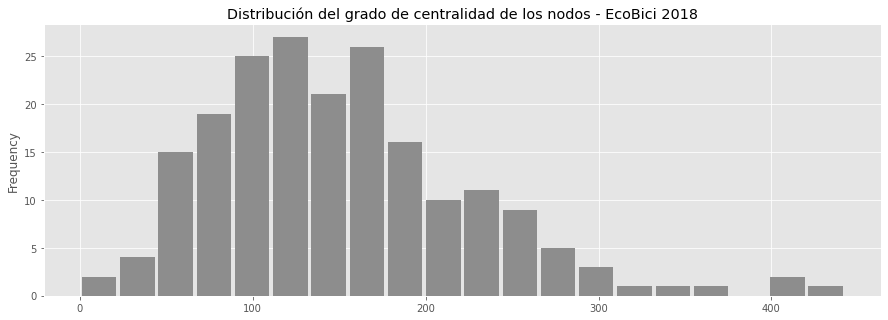

In [79]:
plt.figure(figsize=(15,5))

plt.subplot(1,1,1)

dc18 = pd.Series(nx.degree_centrality(b18_multidi).values())
#dc18 = pd.Series([b18_multidi.degree[n]/(b18_multidi.number_of_nodes()-1) for n in b18_multidi.nodes()])

dc18.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#8d8d8d')

plt.title('Distribución del grado de centralidad de los nodos - EcoBici 2018');

In [80]:
import nxviz as nv

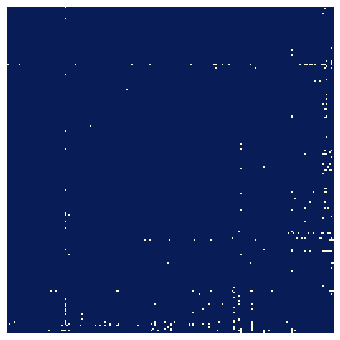

In [81]:
ady = nv.MatrixPlot(G18)
ady.draw()

En primer lugar, lo que muestran los histogramas es que las frecuencias cercanas a cero son pocas. Es decir, ambos extremos de la distribución son bajos por lo que la misma se parece bastante a una normal. Si contrastamos esto con la matriz de adyacencia, pareceríamos estar frente a una red con un alto grado de conectividad.

## **Ejercitación**

Armar una función que devuelva un histograma con:

**a.** la distribución de grados (node degree) de los nodos para cada año, ó

**b.** la distribución del grado de centralidad (degree centrality) de los nodos para cada año.

Hacer que dicha función permita comparar dos distribuciones distintas (una por eje)

¿Se aprecia algún patrón o comportamiento en alguna de ellas? 

Complementar el análisis previo con un gráfico que devuevla en 4 ejes distintos las matrices de adyacencia para cada uno de los 4 grafos (de 2015 a 2018). 

Pista: la matriz de adyacencia indica caminos entre pares sin importar la clase que se instancia para crear el objeto grafo. Por ahí puedas usar directamente la que requiera menos uso de memoria.

In [82]:
# Desarrollar ejercicio

### Solución

In [83]:
# creamos una función para plotear una distribución por eje
def plotea_distribucion(frecuencias_año1, color_año1, titulo_año1,
                        frecuencias_año2, color_año2, titulo_año2):
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    
    frecuencias_año1.plot.hist(grid=True, 
                               bins=20, 
                               rwidth=0.9, 
                               color=color_año1,
                               ax=ax1)
    ax1.set_title(titulo_año1)
    
    frecuencias_año2.plot.hist(grid=True, 
                               bins=20, 
                               rwidth=0.9, 
                               color=color_año2,
                               ax=ax2)
    ax2.set_title(titulo_año2);

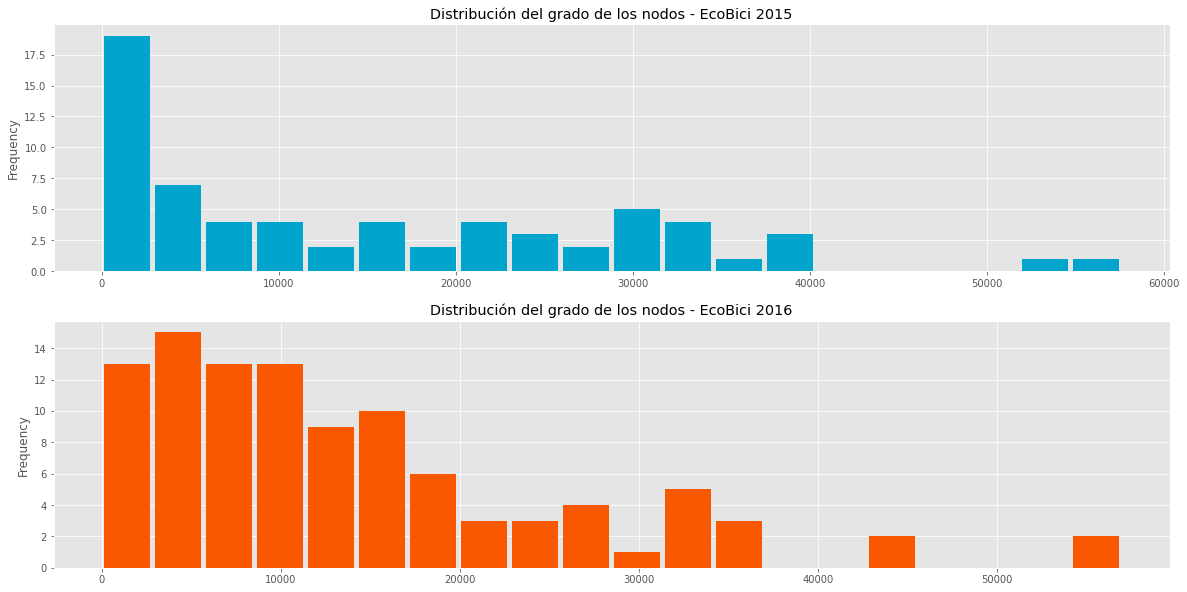

In [84]:
# creamos una serie con el degree de los nodos para 2015, 2016 y 2017.
nd15 = pd.Series([b15_multidi.degree(n) for n in b15_multidi.nodes()])
nd16 = pd.Series([b16_multidi.degree(n) for n in b16_multidi.nodes()])
nd17 = pd.Series([b17_multidi.degree(n) for n in b17_multidi.nodes()])


# Ploteamos 2015 vs 2016,
plotea_distribucion(frecuencias_año1=nd15, color_año1='#00A4CCFF', 
                    titulo_año1='Distribución del grado de los nodos - EcoBici 2015',
                    frecuencias_año2=nd16, color_año2='#F95700FF', 
                    titulo_año2='Distribución del grado de los nodos - EcoBici 2016')

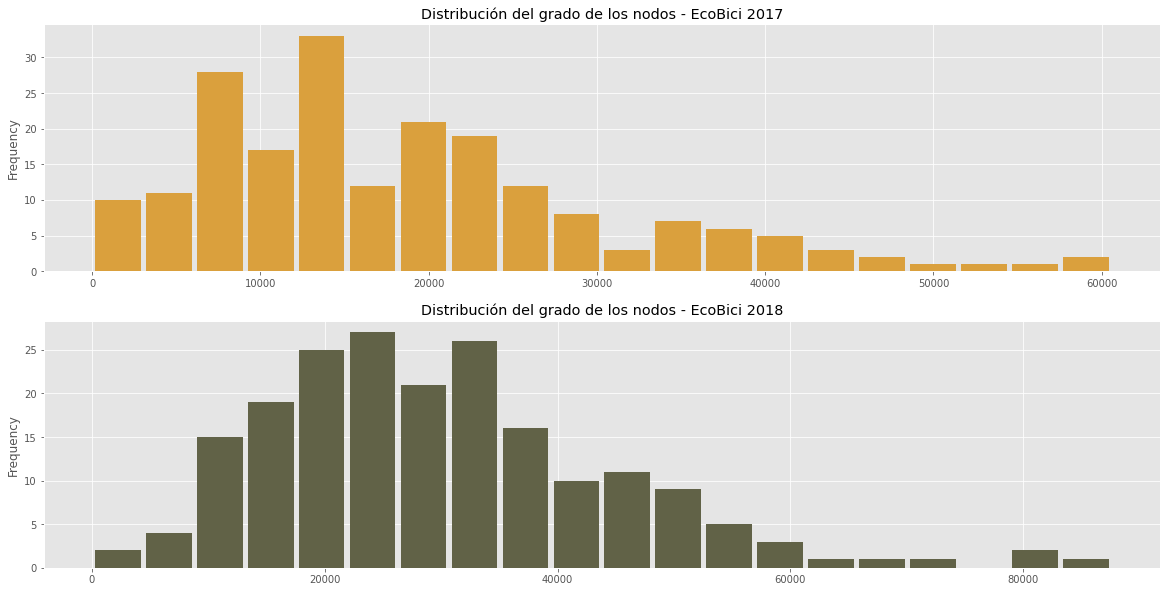

In [85]:
# y tambien ploteamos 2017 vs 2018
plotea_distribucion(frecuencias_año1=nd17, color_año1='#DAA03DFF', 
                    titulo_año1='Distribución del grado de los nodos - EcoBici 2017',
                    frecuencias_año2=nd18, color_año2='#616247FF', 
                    titulo_año2='Distribución del grado de los nodos - EcoBici 2018')

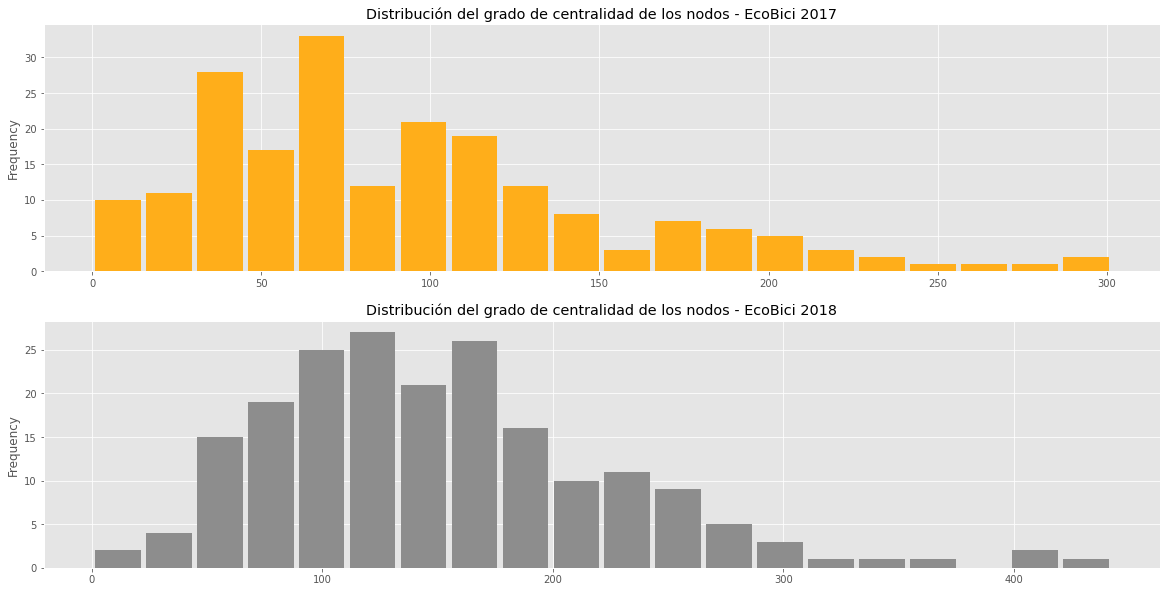

In [86]:
# podriamos haber hecho lo mismo pero con degree centrality
dc17 = pd.Series(nx.degree_centrality(b17_multidi).values())

plotea_distribucion(frecuencias_año1=dc17, color_año1='#ffae1a', 
                    titulo_año1='Distribución del grado de centralidad de los nodos - EcoBici 2017',
                    frecuencias_año2=dc18, color_año2='#8d8d8d', 
                    titulo_año2='Distribución del grado de centralidad de los nodos - EcoBici 2018')

In [87]:
# Ahora creamos 4 matrices de adyacencia a partir de grafos no dirigidos
A15 = nx.to_numpy_matrix(G15)
A16 = nx.to_numpy_matrix(G16)
A17 = nx.to_numpy_matrix(G17)
A18 = nx.to_numpy_matrix(G18)

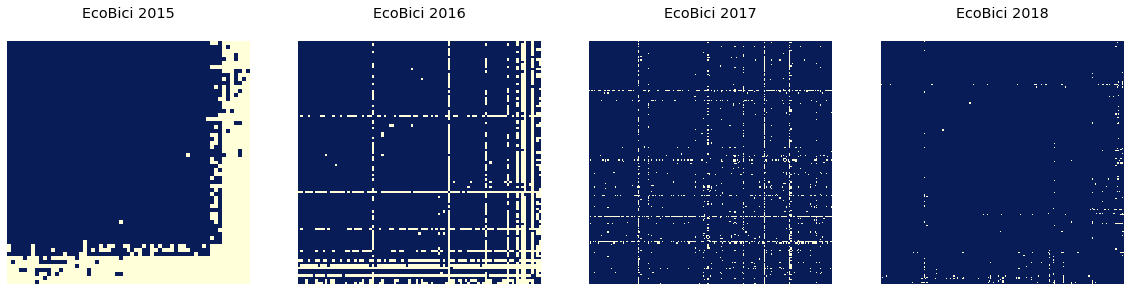

In [88]:
# y las ploteamos!
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

ax1.matshow(A15, cmap=plt.get_cmap('YlGnBu'))
ax1.set_axis_off()
ax1.set_title('EcoBici 2015')

ax2.matshow(A16, cmap=plt.get_cmap('YlGnBu'))
ax2.set_axis_off()
ax2.set_title('EcoBici 2016')

ax3.matshow(A17, cmap=plt.get_cmap('YlGnBu'))
ax3.set_axis_off()
ax3.set_title('EcoBici 2017')

ax4.matshow(A18, cmap=plt.get_cmap('YlGnBu'));
ax4.set_axis_off()
ax4.set_title('EcoBici 2018');

Tal y como dijimos antes, la red EcoBici muestra una evolución creciente de conexiones adyacentes. Esto no habla más que de una red que se va completando a lo largo del tiempo. Con más usuarios y conexiones bidireccionales entre nodos.

### 3. 5. El camino más corto en la red EcoBici  

Como adelantemos en la clase anterior, la distancia dentro de un grafo (conocida como `shortest path` o `geodesic path`) se entiende como la cantidad de arcos mínimos que son necesarios recorrer para ir desde un nodo a cada uno de los restantes de la red. 

En nuestro caso no debemos perder de vista que, en ejemplo que elegimos para trabajar, las estaciones no se disponen secuencialmente. Es decir, no funcionan como "paradas" que respetan un orden. 

El hecho de poder ir de una estación a cualquier otra de la red, hace que la noción de adyacencia se vuelva la cuestión central. Por ende, no debemos confundir los resultados que obtengamos con el algoritmo `shortest_path`. Veamos un ejemplo de lo que estamos diciendo!

In [89]:
# calculamos los caminos mas cortos entre todas las estaciones de origen y destino
largo_caminos=dict(nx.all_pairs_shortest_path_length(b18_multidi))

In [90]:
# y vemos cuales están conectados por más de una adyacencia, raro no?
for k,v in largo_caminos.items():
    for n in b18_multidi.nodes:
        try:
            if v[n] > 1:
                print('Path entre {} y {}: {}'.format(k,n,v[n]))
        except:
            pass

Path entre Parque Lezama y Santos Dumont y Otero: 2
Path entre Parque Lezama y Roseti: 2
Path entre Parque Lezama y PALACIO LEZAMA: 2
Path entre Austria y French y Santos Dumont y Otero: 2
Path entre Austria y French y PALACIO LEZAMA: 2
Path entre Austria y French y Juan Manuel Blanes: 2
Path entre Austria y French y Pinzon y M. Rodriguez: 2
Path entre Cementerio de la Recoleta y PALACIO LEZAMA: 2
Path entre Cementerio de la Recoleta y Plaza Hipolito Bouchard: 2
Path entre Quintana y Santos Dumont y Otero: 2
Path entre Quintana y Urquiza: 2
Path entre Quintana y PALACIO LEZAMA: 2
Path entre Quintana y Plaza Garay: 2
Path entre Agüero y PALACIO LEZAMA: 2
Path entre Agüero y Hospital Argerich: 2
Path entre Agüero y Juan Manuel Blanes: 2
Path entre Ecuador y PALACIO LEZAMA: 2
Path entre Ministro Carranza y PALACIO LEZAMA: 2
Path entre Sarandí y Santos Dumont y Otero: 2
Path entre Sarandí y PALACIO LEZAMA: 2
Path entre Pasco y PALACIO LEZAMA: 2
Path entre Pasco y Plaza Hipolito Bouchard: 2

In [91]:
# elijamos un caso al azar para ver con qué otras estaciones tienen dos adyacencias
for n in b18_multidi.nodes():
    cmc = nx.shortest_path_length(b18_multidi, source='Virrey Liniers', target=n)
    if cmc > 1:
        print('El camino mas corto entre Virrey Liniers y {} tiene {} ejes'.format(n,cmc))

El camino mas corto entre Virrey Liniers y Santos Dumont y Otero tiene 2 ejes
El camino mas corto entre Virrey Liniers y Suipacha y Arroyo tiene 2 ejes
El camino mas corto entre Virrey Liniers y Della Paolera tiene 2 ejes
El camino mas corto entre Virrey Liniers y Ingeniero Butty tiene 2 ejes
El camino mas corto entre Virrey Liniers y PALACIO LEZAMA tiene 2 ejes
El camino mas corto entre Virrey Liniers y Plaza Hipolito Bouchard tiene 2 ejes


In [92]:
# supuestamente, para llegar hasta la estación Bouchard habría que pasar por Aime Paine. Más raro aún no?
nx.shortest_path(b18_multidi, source='Virrey Liniers', target='Plaza Hipolito Bouchard')

['Virrey Liniers', 'Aime Paine', 'Plaza Hipolito Bouchard']

Por el tipo de red con el que estamos trabajando, las conexiones entre nodos sigue una lógica bidireccional. Es decir, un usuario puede retirar su bicicleta en cualquier estación de origen y dejarla en otra de destino. En otras palabras, las conexiones involucran mayormente dos nodos!

In [93]:
# busquemos el id de las estaciones involucradas en el shortest path de Virrey Liniers
df['18'][(df['18']['bici_nombre_estacion_origen']== 'Virrey Liniers') & 
         (df['18']['bici_nombre_estacion_destino']== 'Aime Paine')]

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
2254365,141756.0,2018-05-13 18:02:22,46.0,Virrey Liniers,139,Aime Paine,151.0,MASCULINO,26.0
2730657,412711.0,2018-02-20 16:48:20,49.0,Virrey Liniers,139,Aime Paine,151.0,MASCULINO,19.0
2970439,83557.0,2018-01-01 01:24:07,46.0,Virrey Liniers,139,Aime Paine,151.0,MASCULINO,25.0


In [94]:
# ahora el último tramo
df['18'][(df['18']['bici_nombre_estacion_origen']== 'Aime Paine') & 
         (df['18']['bici_nombre_estacion_destino']== 'Plaza Hipolito Bouchard')]

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
1982098,537199.0,2018-06-10 19:11:20,6.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,38.0
1983627,422362.0,2018-06-10 16:22:45,6.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,52.0
1989007,537199.0,2018-06-09 19:00:00,7.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,38.0
1990126,422362.0,2018-06-09 16:59:21,7.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,52.0
2003377,396274.0,2018-06-08 12:55:42,5.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,22.0
...,...,...,...,...,...,...,...,...,...
2913874,105022.0,2018-01-15 07:59:02,7.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,30.0
2921491,498720.0,2018-01-12 13:38:42,7.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,FEMENINO,28.0
2928295,130763.0,2018-01-10 20:36:22,7.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,36.0
2942496,463163.0,2018-01-07 17:42:22,84.0,Aime Paine,151,Plaza Hipolito Bouchard,128.0,MASCULINO,30.0


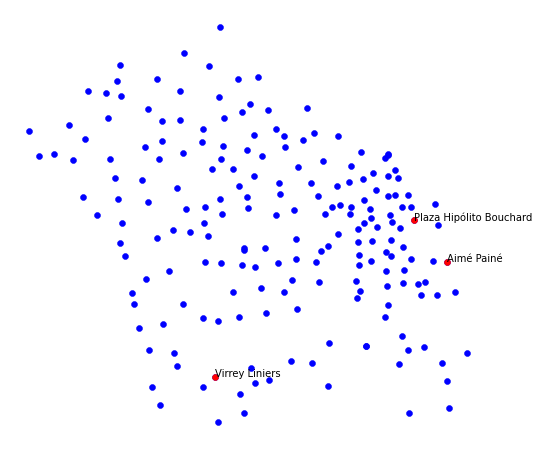

In [95]:
# y ubiquemoslas en un mapa
sht_path = estaciones[estaciones.NRO_EST.isin([128,139,151])].copy()
sht_path['coords'] = list(zip(sht_path.geometry.x, sht_path.geometry.y))

labels = dict(zip(sht_path.NOMBRE, sht_path.coords))

fig, ax = plt.subplots(figsize=(12,8))
estaciones.plot(ax=ax, color='blue')

sht_path.plot(ax=ax,color='red')


for k, v in labels.items():
        ax.annotate(text = k,
                    xy=v);

ax.set_axis_off();

¿Tiene esto algún sentido? Sí y no, pero debemos interpretarlo correctamente. El hecho de que el shortest path entre Virrey Liniers y Plaza Bouchard involucre a Aimé Painé no significa que esta estación es la más cercana para poder conectar ambos extremos.

Dada la topología de nuestra red (conexiones adyacentes), lo que nos está indicando un `shortest path == 2` es que ambos nodos no se encuentran conectados de manera adyacente y que el camino más corto para poder vincularlos, involucraría necesariamente una adyacencia adicional. De hecho, puede revisar que en el resultado de largo de caminos, no hay ningún resultado superior a dos.

Esto es porque las conexiones en nuestra red se dan entre pares de estaciones. Aquellas que no son adyacentes, necesitarán necesariamente un eje adicional que las una. Esto siempre que estemos calculando el camino más corto con caminos sin ponderar (todos los ejes valiendo 1).

In [96]:
# recuperemos esta función que vimos la clase anterior para graficar esto último que venimos diciendo
def existe_path_entre_nodos(grafo, nodo1, nodo2):
    """
    Verifica si los nodos 1 y 2 de un grafo se encuentran conectados por un mismo eje.
    """

    # inicializamos una lista con el extremo inicial de cada path o camino que vamos a recorrer
    cabeceras = [nodo1]
    
    # creamos un contador para almacenar la cantidad de nodos intermedios
    distancia = 0

    # iteramos la lista de nodos cabecera que almacenamos previamente
    for nodo in cabeceras:

        # Obtenemos los vecinos de cada nodo cabecera
        vecinos = grafo.neighbors(nodo)

        # y verificamos si el nodo de destino se encuentra dentro de los vecinos del nodo cabecera
        if nodo2 in vecinos:
            print('Existe un camino adyacente entre los nodos {} y {}'.format(nodo1, nodo2))
            # agregamos un nodo de distancia por conexión adyacente
            distancia += 1
            return distancia
            
        else:
            print('No existe adyacencia entre nodos {} y {}'.format(nodo1, nodo2))
            return distancia 

In [97]:
# Virrey Liniers y Plaza Bouchard no están conectadas de manera adyacente
existe_path_entre_nodos(grafo=b18_multidi, nodo1='Virrey Liniers', nodo2='Plaza Hipolito Bouchard')

No existe adyacencia entre nodos Virrey Liniers y Plaza Hipolito Bouchard


0

In [98]:
# Pero sí existe un path entre Aime Paine y Virrey Liniers
existe_path_entre_nodos(grafo=b18_multidi, nodo1='Virrey Liniers', nodo2='Aime Paine')

Existe un camino adyacente entre los nodos Virrey Liniers y Aime Paine


1

In [99]:
# Como así también entre la primera y Plaza Bouchard
existe_path_entre_nodos(grafo=b18_multidi, nodo1='Aime Paine', nodo2='Plaza Hipolito Bouchard')

Existe un camino adyacente entre los nodos Aime Paine y Plaza Hipolito Bouchard


1

Pero ... **¿por qué Aimé Painé y no otra estación intermedia entre Virrey Liniers y Plaza Bouchard si todos los ejes valen 1?**

En la [documentación oficial de NetworkX](https://networkx.org/documentation/stable/_modules/networkx/algorithms/shortest_paths/unweighted.html#bidirectional_shortest_path) se deja en claro que:
```
Notes
-----
There may be more than one shortest path between a source and target.
This returns only one of them.
```

Por lo tanto, siempre que haya más de un camino más corto el resultado dependerá de la orden de selección de los ejes. Y esto, básicamente, queda sujeto a:

1. Qué estación espeifiquemos como sucesor/predecesor (el source y el target)
2. Cómo estén ordenados los ejes en nuestro grafo.

En nuestro cálculo previo, los ejes eran `unweighted`, por eso el path más corto se elige con el método `bidirectional`:

In [100]:
# vemos el orden original
nx.bidirectional_shortest_path(b18_multidi, source='Virrey Liniers', target='Plaza Hipolito Bouchard')

['Virrey Liniers', 'Aime Paine', 'Plaza Hipolito Bouchard']

In [101]:
# y lo invertimos
nx.bidirectional_shortest_path(b18_multidi, source='Plaza Hipolito Bouchard', target='Virrey Liniers')

['Plaza Hipolito Bouchard', 'Hospital Francés', 'Virrey Liniers']

#### 3.5.1. Breve demostración sobre selección de caminos más cortos entre source y target

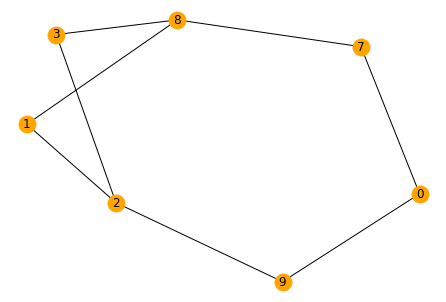

In [102]:
# creemos un grafo no dirigido donde, para conectar dos extremos, se pueda pasar por más de un camino
plt.figure(figsize=(6,4))
G = nx.from_edgelist([[1,2],[2,3],[7,8],[3,8],[1,8], [2,9],[9,0],[0,7]])
nx.draw(G, with_labels=True, node_color='orange')

In [103]:
# vemos que para conectar 2 y 8 hay al menos dos caminos
list(nx.all_shortest_paths(G, 2, 8))

[[2, 1, 8], [2, 3, 8]]

In [104]:
# de los cuales uno se elige primero según especifiquemos un par source/target
nx.shortest_path(G=G, source=2, target=8)

[2, 3, 8]

In [105]:
# y vicebersa
nx.shortest_path(G=G, source=8, target=2)

[8, 1, 2]

La idea no es entrar en detalle en cómo se elige el path (los que estén interesados en urgar un poco más, el orden de selección de los ejes depende del método `_bidirectional_pred_succ` el cual se puede explorar [acá](https://networkx.org/documentation/stable/_modules/networkx/algorithms/shortest_paths/unweighted.html#bidirectional_shortest_path)). 

Por el contrario, lo que buscamos dejar en claro es que, en el contexto de nuestro grafo, el resultado de un shortest path superior a 1, sólo nos estaría mostrando pares de nodos que no se encuentran conectados adyacentemente y que, para ser conectados, necesitarían al menos una conexión adicional.

In [106]:
# como los ejes valen todos 1, podemos tener más de un camino más corto
all_sht = list(nx.all_shortest_paths(G=b18_multidi, source='Virrey Liniers', target='Plaza Hipolito Bouchard'))

In [107]:
# los que se pueden ver ordenados a continuación!
sorted(nx.all_shortest_paths(G=b18_multidi, source='Virrey Liniers', target='Plaza Hipolito Bouchard'))

[['Virrey Liniers', '25 de Mayo', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', '9 de Julio', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Acevedo', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Acuña de Figueroa', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Aduana', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Agüero', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Aime Paine', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Alsina', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Aranguren', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Araoz', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Arenales', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Arenales y Aguero', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Armenia', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Austria y French', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Ayacucho', 'Plaza Hipolito Bouchard'],
 ['Virrey Liniers', 'Azopardo y Chile', 'Plaza Hipolito Bouchard'],
 ['Virrey 

In [108]:
# ... en total
len(all_sht)

137

Esto significa, que ¿si ponderaramos los ejes con algún atributo podríamos tener un camino más corto que nos indique otra cosa que estaciones no conectadas adyacentemente? 

Nuevamente lo mismo, la noción de camino más corto queda sujeta a la topología de la red. Es posible que, tomando una bicicleta y yendo de una estación a la otra se llegue antes. Aunque si analizáramos un camino más corto ponderado por tiempo de uso el resultado sería el siguiente:

In [109]:
# los recorridos de la red indicarían que ...
nx.shortest_path(G=b18_multidi, source='Virrey Liniers', 
                 target='Plaza Hipolito Bouchard', 
                 weight='bici_tiempo_uso')

['Virrey Liniers', 'EEUU y Boedo', '25 de Mayo', 'Plaza Hipolito Bouchard']

... sumando todos los tiempos de uso de los usuarios, la forma más corta en la que se llegaría sería uniendo las estaciones previas. Ahora bien, y como dijimos, esto no es algo necesariamente cierto. Sino antes, los patrones existentes en el dataset del año que elejimos para explorar.

### 3.6. Betweeness centrality en la red EcoBici  

La topología de nuestra red no sólo afecta la interpretación del `shortest_path`. Dijimos que nuestra red se compone de una serie de conexiones eminentemente adyacentes. En este contexto, la idea de un nodo que tenga un valor de intermediación al resto pierde fuerza. Básicamente porque la mayoría de las conexiones se dan 1 a 1.

Para graficarlo hagamos un breve ejemplo con un [grafo de barbell](https://en.wikipedia.org/wiki/Barbell_graph#:~:text=In%20the%20mathematical%20discipline%20of,an%20endpoint%20in%20each%20clique). Sin adentrarnos mucho en el tema, digamos que este tipo de grafos corresponde a la familia de los [cliques](https://es.wikipedia.org/wiki/Clique), donde la principal característica es que los ejes no son dirigidos y todos se encuentran conectados entre sí de manera adyacente. 

In [110]:
# Creamos un barbell graph de 5 nodos con 1 puente
BG = nx.barbell_graph(m1=5, m2=1)

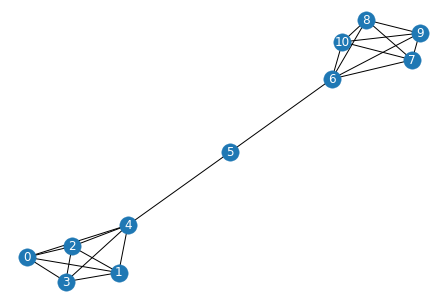

In [111]:
# Y lo graficamos!
nx.draw(BG, with_labels=True, font_color='white')

¿Cuál les parece que sería el nodo con mayor valor de intermediación?

In [112]:
# Efectivamente, el número 5 es el nodo por donde pasa el mayor número de caminos intermedios!
nx.betweenness_centrality(BG)

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.5333333333333333,
 6: 0.5333333333333333,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 5: 0.5555555555555556}

Con este ejemplo, buscamos mostrar de una manera lo más evidente posible cómo trabaja un nodo con alto valor de intermediación. En nuestra red EcoBici, algo así no sería posible porque la estructura de las conexiones es totalmente diferente. Las estaciones tienden a conectarse 1 a 1!

In [113]:
# y por lo tanto los valores de centralidad son practicamente iguales!
nx.betweenness_centrality(G18)

{6: 3.0388741200511e-05,
 200.0: 3.2918235203789176e-05,
 166: 3.6655961494383535e-05,
 115.0: 3.6655961494383535e-05,
 85: 3.3820622562345444e-05,
 69.0: 3.6655961494383535e-05,
 58: 3.6655961494383535e-05,
 77.0: 3.0388741200511e-05,
 91: 3.6655961494383535e-05,
 106.0: 3.6655961494383535e-05,
 187: 3.6655961494383535e-05,
 134.0: 3.6655961494383535e-05,
 149: 3.6655961494383535e-05,
 57.0: 3.6655961494383535e-05,
 160: 3.6655961494383535e-05,
 38.0: 3.6655961494383535e-05,
 141: 3.6655961494383535e-05,
 16.0: 3.6655961494383535e-05,
 150: 3.6655961494383535e-05,
 14: 3.6655961494383535e-05,
 137.0: 3.6655961494383535e-05,
 84: 3.6655961494383535e-05,
 146.0: 3.6655961494383535e-05,
 86: 3.6655961494383535e-05,
 29.0: 3.6655961494383535e-05,
 199.0: 3.1969325180259535e-05,
 90: 3.293726826642101e-05,
 64.0: 3.6655961494383535e-05,
 1: 3.6655961494383535e-05,
 22.0: 3.293726826642101e-05,
 144: 3.6655961494383535e-05,
 33.0: 3.6655961494383535e-05,
 18: 3.6655961494383535e-05,
 50: 2.